In [1]:
from os.path import join
import json
import csv
import glob

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from IPython.display import Image
from scipy.stats import t, sem, ttest_rel

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
data_dir = '/Users/benkaehler/Data/HMP/'

In [5]:
eval_comp = read_csv(join(data_dir, 'eval_comp_results_nude.tsv'), sep='\t')

In [6]:
old_labels = 'shotgun-rel-freqs', 'uniform-rel-freqs', 'nude-shotgun-rel-freqs'
new_labels = 'Bias Corrected Shotgun', 'Uniform', 'Shotgun'
for old, new in zip(old_labels, new_labels):
    eval_comp.loc[eval_comp['class weights'] == old, 'class weights'] = new

In [7]:
eval_comp['fold'] = None
for fold_dir in glob.glob(join(data_dir, 'results', 'folds', 'fold-*')):
    _, fold = fold_dir.rsplit('-', 1)
    with open(join(fold_dir, 'sample_test.json')) as fh:
        samples = json.load(fh)
    for sample in samples:
        eval_comp.loc[eval_comp['sample'] == int(sample), 'fold'] = fold

In [8]:
grouped = eval_comp.groupby(['class weights', 'level', 'fold'])
def stats(x):
    return Series(x['Bray-Curtis'].mean(), index=['mean'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)
grouped = figure4.groupby(['class weights', 'level'])
def stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu - se, mu + se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)

In [9]:
%%R -i figure4

figure4 <- figure4[figure4$class.weights != 'Bias Corrected Shotgun',]

cbPalette <- c("#009E73", "#999999", "#E69F00")
cbPalette <- c("#009E73", "#E69F00")

ggplot(figure4, aes(x=level, y=mean, 
                    group=class.weights,
                    colour=class.weights)) + 
geom_line() + 
theme_bw() +
  labs(y='Bray-Curtis Dissimilarity', x='Taxonomy Level') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights")) +
  scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c('Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species')) +
  geom_point() +
  geom_errorbar(aes(ymin=lower, ymax=upper), width=.2,
                 position=position_dodge(0.05)) +
  theme(axis.text.x = element_text(angle = 45, vjust=0.5))

ggsave(file="nude-shotgun-bray-curtis.png", width=5, height=5, dpi=300)

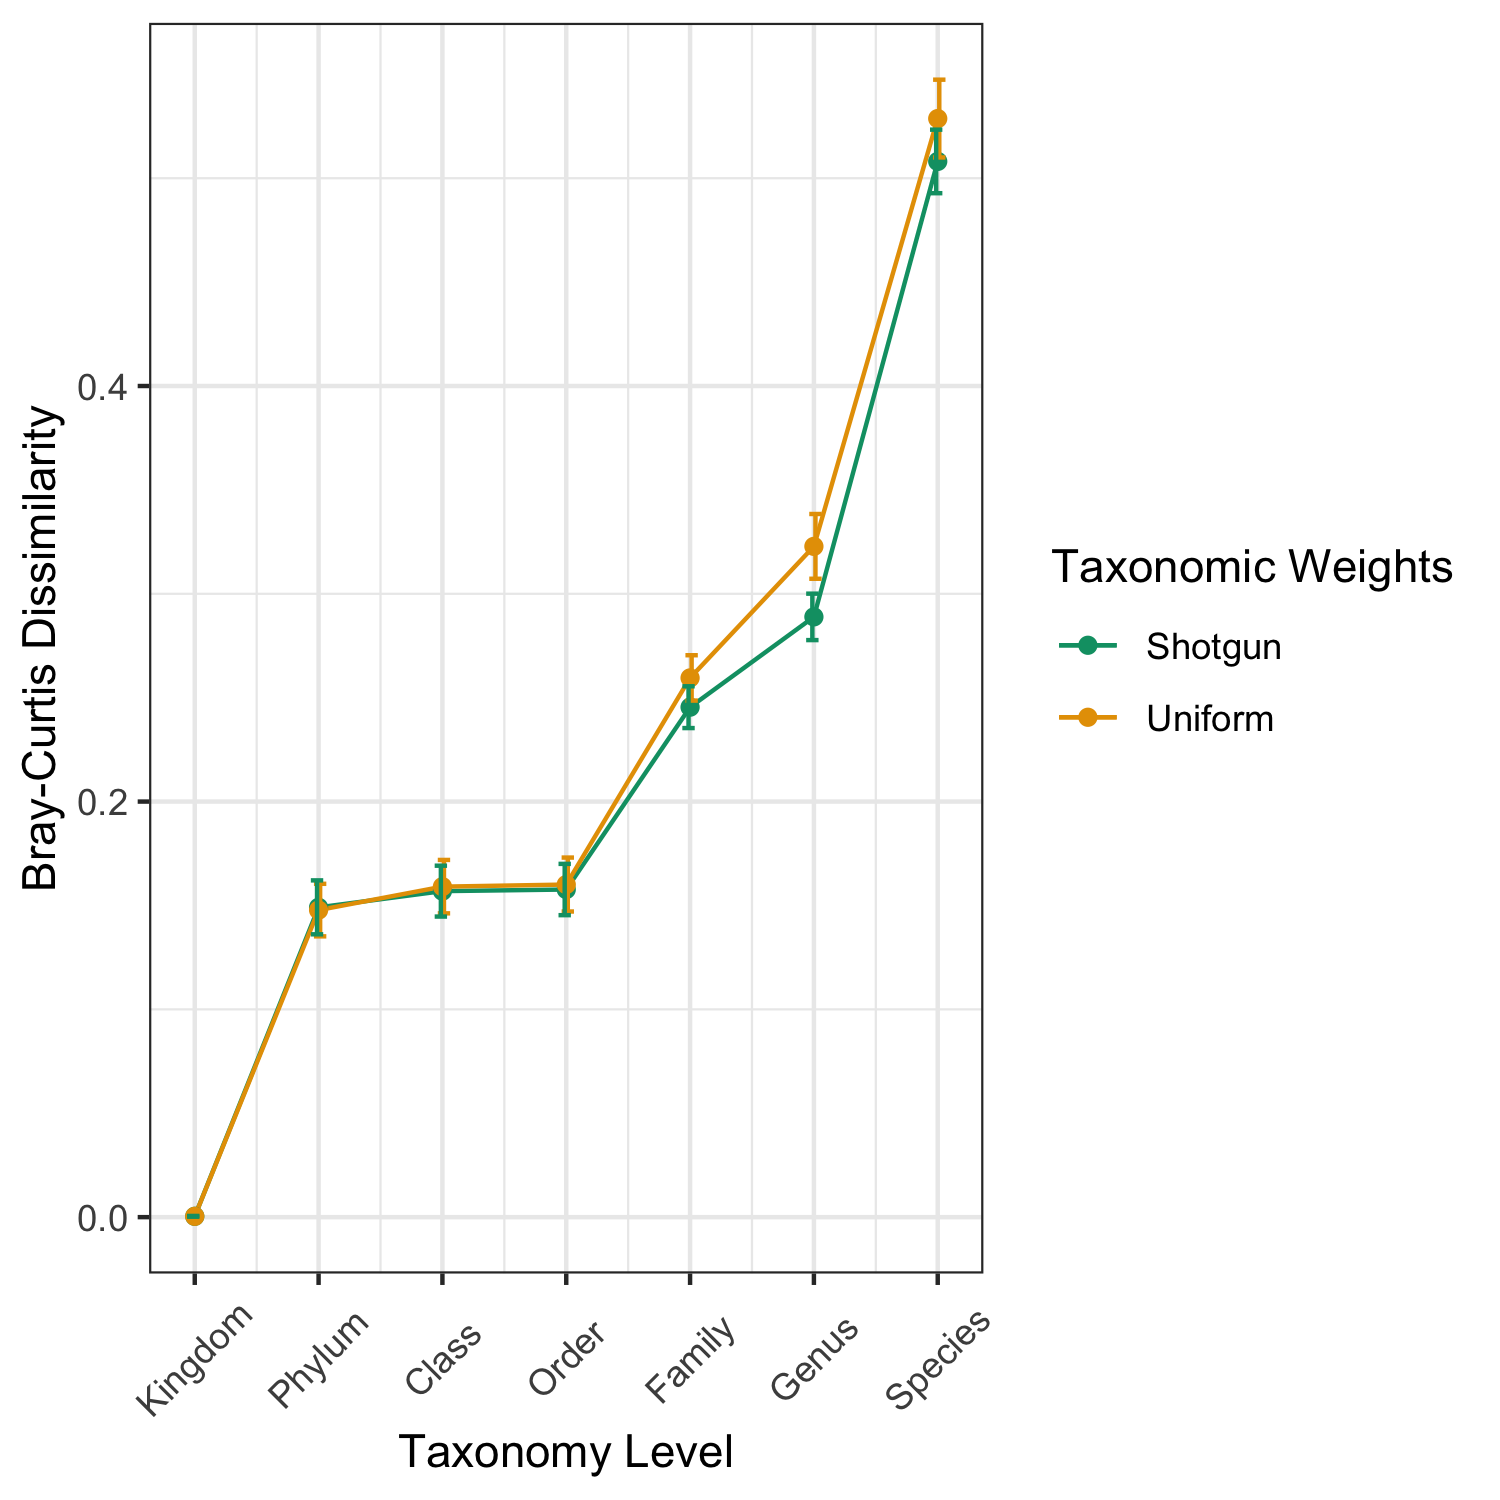

In [10]:
Image("nude-shotgun-bray-curtis.png")

In [11]:
#grouped = eval_comp.groupby(['class weights', 'level', 'fold'])
#def stats(x):
#    return Series(x['TDR'].mean(), index=['mean'])
#figure4 = grouped.apply(stats)
#figure4.reset_index(inplace=True)
grouped = eval_comp.groupby(['class weights', 'level'])
def stats(x):
    mu = x['TDR'].mean()
    se = sem(x['TDR'])
    lower, upper = mu - se, mu + se
    return Series([mu, lower, upper, se], index=['mean', 'lower', 'upper', 'se'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)

In [12]:
%%R -i figure4

figure4 <- figure4[figure4$class.weights != 'Bias Corrected Shotgun',]

cbPalette <- c("#009E73", "#999999", "#E69F00")
cbPalette <- c("#009E73", "#E69F00")

ggplot(figure4, aes(x=level, y=mean, 
                    group=class.weights,
                    colour=class.weights)) + 
geom_line() + 
theme_bw() +
  labs(y='Taxon Detection Rate', x='Taxonomy Level') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights")) +
  scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c('Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species')) +
  geom_point() +
  geom_errorbar(aes(ymin=lower, ymax=upper), width=.2,
                 position=position_dodge(0.05)) +
  theme(axis.text.x = element_text(angle = 45, vjust=0.5))

ggsave(file="nude-shotgun-tdr.png", width=5, height=5, dpi=300)

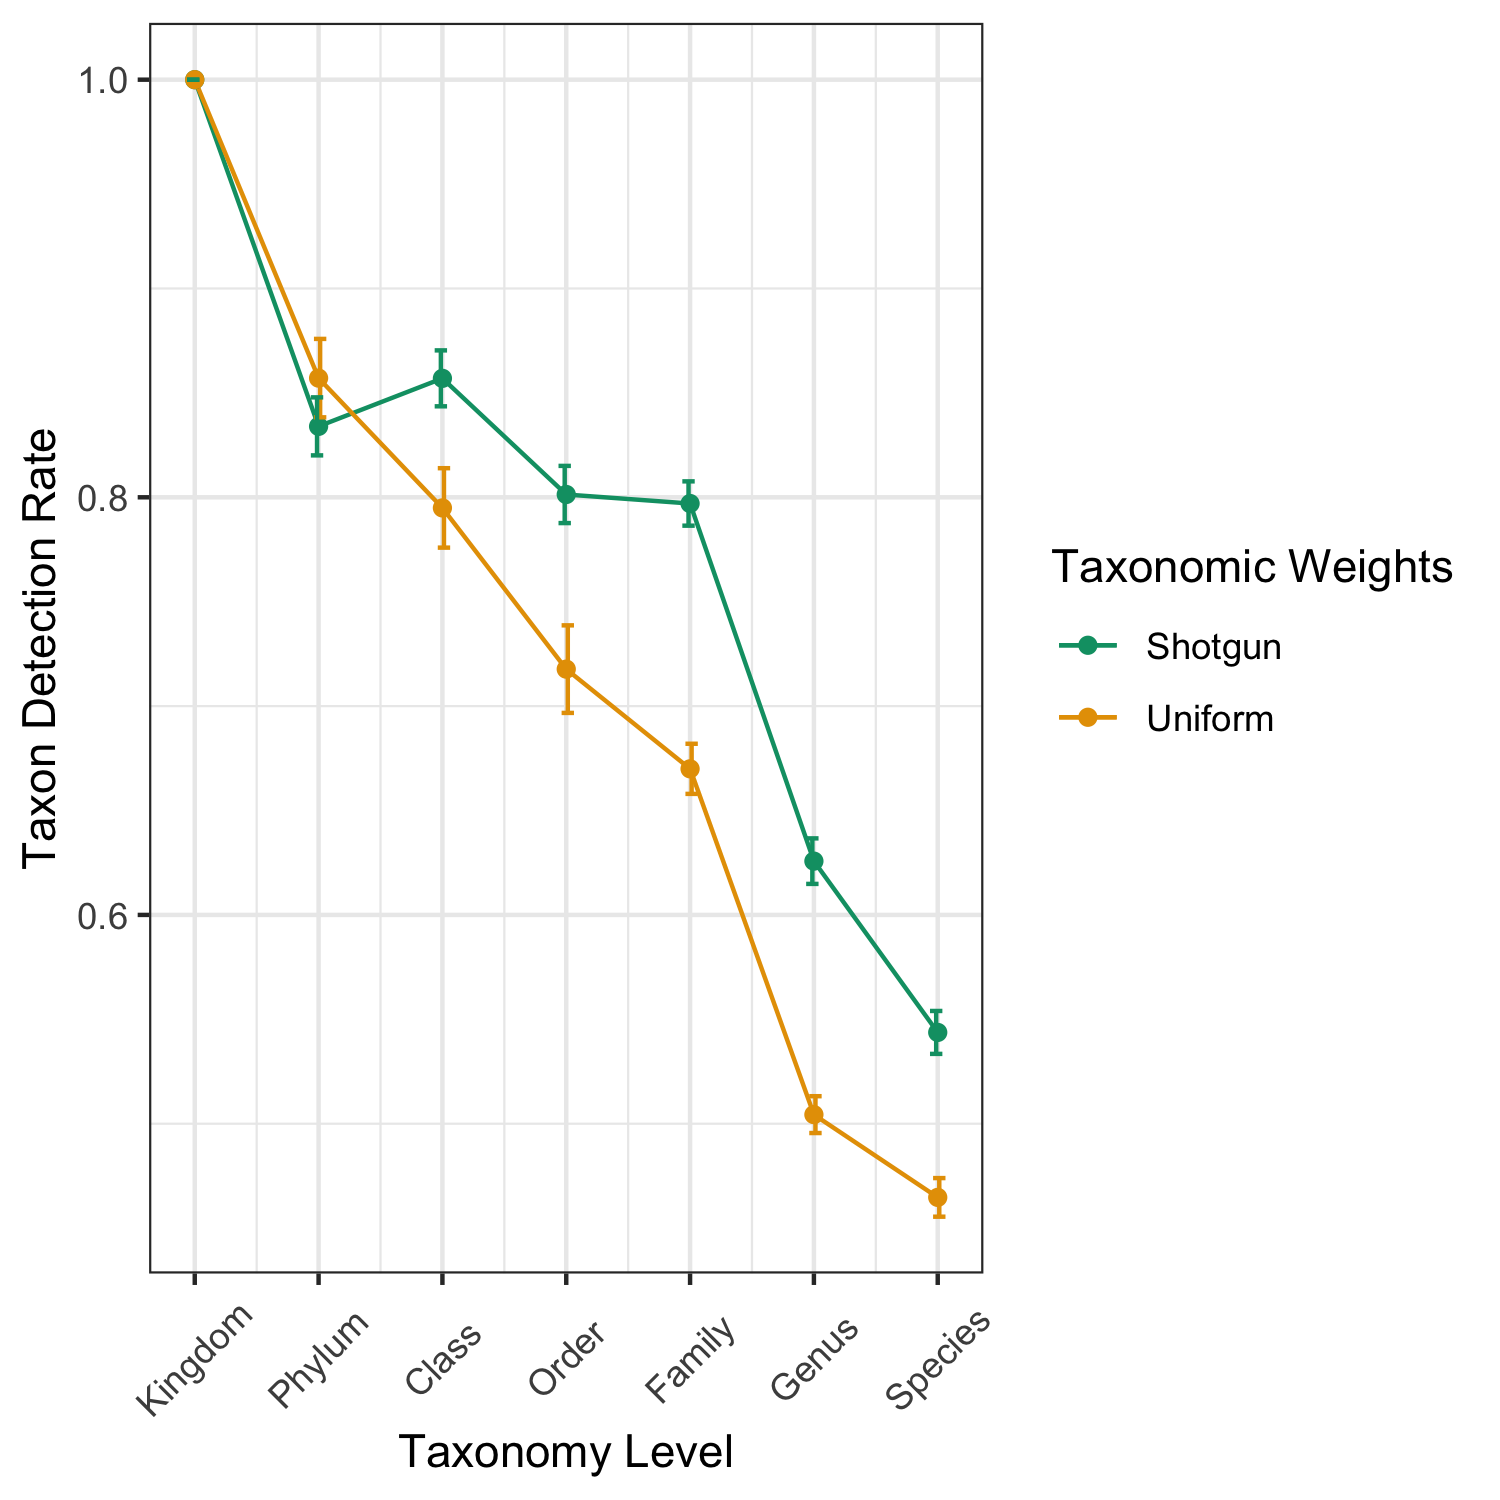

In [13]:
Image("nude-shotgun-tdr.png")

In [43]:
uniform = eval_comp[eval_comp['class weights'] == 'Uniform']
shotgun = eval_comp[eval_comp['class weights'] == 'Shotgun']
print(ttest_rel(uniform[uniform['level'] == 7]['TDR'], shotgun[shotgun['level'] == 7]['TDR']))
print(ttest_rel(uniform[uniform['level'] == 6]['TDR'], shotgun[shotgun['level'] == 7]['TDR']))

Ttest_relResult(statistic=-13.143006738907602, pvalue=1.4056368284224102e-20)
Ttest_relResult(statistic=-4.3949154201068579, pvalue=3.8610775143596009e-05)


In [34]:
figure4

,class weights,level,mean,lower,upper,se
0,Bias Corrected Shotgun,1,1.000000,NaN,NaN,0.000000
1,Bias Corrected Shotgun,2,0.865895,0.828829,0.902961,0.014419
2,Bias Corrected Shotgun,3,0.864153,0.827205,0.901101,0.014373
3,Bias Corrected Shotgun,4,0.810223,0.768499,0.851948,0.016232
4,Bias Corrected Shotgun,5,0.767097,0.738284,0.795911,0.011209
5,Bias Corrected Shotgun,6,0.599873,0.572533,0.627212,0.010635
6,Bias Corrected Shotgun,7,0.521173,0.496645,0.545701,0.009542
7,Shotgun,1,1.000000,NaN,NaN,0.000000
8,Shotgun,2,0.833970,0.798260,0.869681,0.013892
9,Shotgun,3,0.856967,0.822535,0.891399,0.013395


In [15]:
grouped = eval_comp.groupby(['class weights', 'level', 'fold'])
def stats(x):
    return Series(x['TAR'].mean(), index=['mean'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)
grouped = figure4.groupby(['class weights', 'level'])
def stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)

In [16]:
%%R -i figure4

cbPalette <- c("#009E73", "#999999", "#E69F00")

ggplot(figure4, aes(x=level, y=mean, 
                    group=class.weights,
                    colour=class.weights)) + 
geom_line() + 
theme_bw() +
  labs(y='Taxon Accuracy Rate', x='Taxonomy Level') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights")) +
  scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c('Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species')) +
  geom_point() +
  geom_errorbar(aes(ymin=lower, ymax=upper), width=.2,
                 position=position_dodge(0.05)) +
  theme(axis.text.x = element_text(angle = 45, vjust=0.5))

ggsave(file="nude-shotgun-tar.png", width=5, height=5, dpi=300)

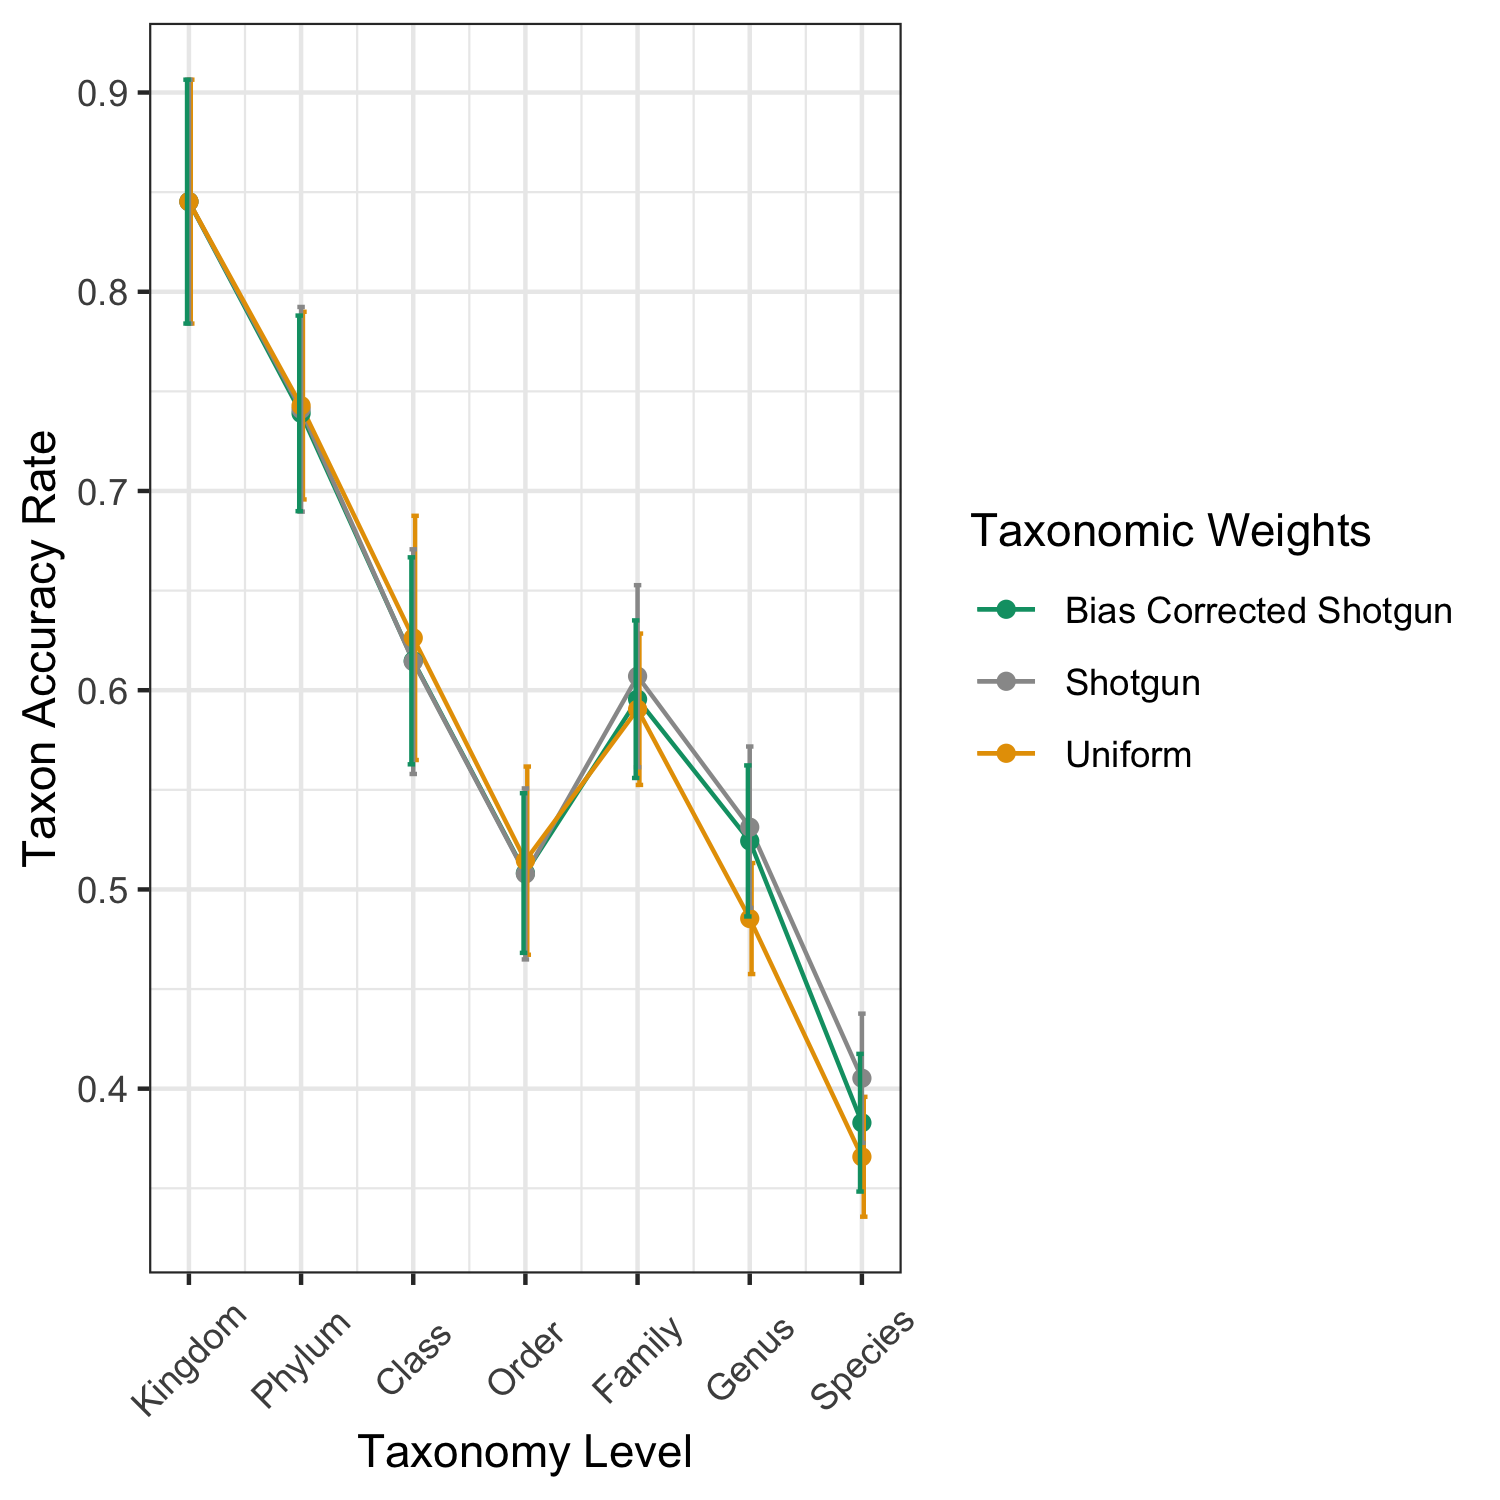

In [17]:
Image("nude-shotgun-tar.png")

In [18]:
grouped = eval_comp.groupby(['class weights', 'level', 'fold'])
def stats(x):
    return Series(x['Jaccard'].mean(), index=['mean'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)
grouped = figure4.groupby(['class weights', 'level'])
def stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(stats)
figure4.reset_index(inplace=True)

In [19]:
%%R -i figure4

cbPalette <- c("#009E73", "#999999", "#E69F00")

ggplot(figure4, aes(x=level, y=mean, 
                    group=class.weights,
                    colour=class.weights)) + 
geom_line() + 
theme_bw() +
  labs(y='Jaccard', x='Taxonomy Level') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights")) +
  scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c('Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species')) +
  geom_point() +
  geom_errorbar(aes(ymin=lower, ymax=upper), width=.2,
                 position=position_dodge(0.05)) +
  theme(axis.text.x = element_text(angle = 45, vjust=0.5))

ggsave(file="nude-shotgun-jaccard.png", width=5, height=5, dpi=300)

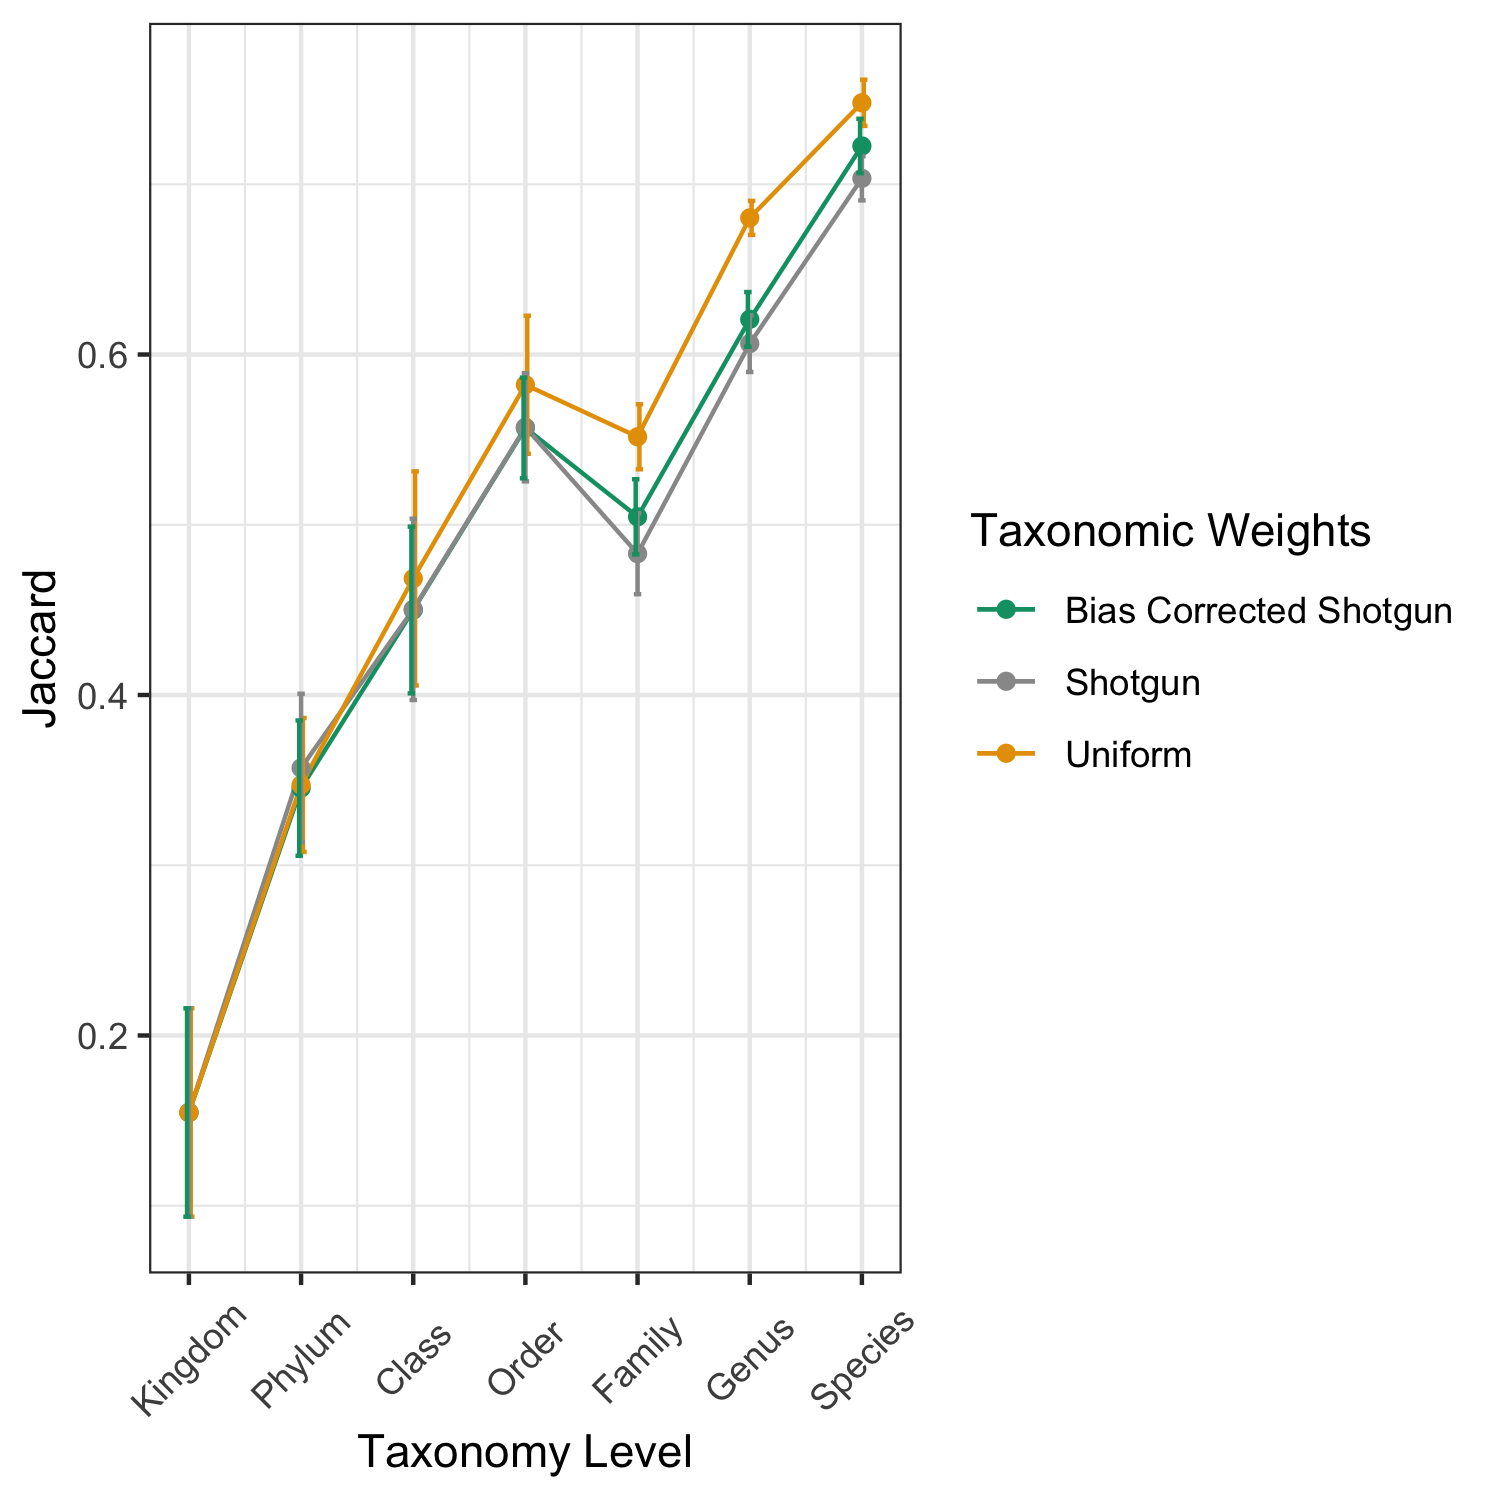

In [20]:
Image("nude-shotgun-jaccard.png")

In [21]:
eval_comp

,Unnamed: 0,sample,level,Observed Taxa,Observed / Expected Taxa,TAR,TDR,Slope,Intercept,r-value,P value,Std Err,Bray-Curtis,Jaccard,r-squared,class weights,fold
0,0,700024437,1,1,1.000000,1.000000,1.000000,NaN,NaN,0.000000,NaN,NaN,2.775558e-16,0.000000,0.000000,Bias Corrected Shotgun,2
1,1,700024437,2,5,1.000000,0.800000,0.800000,0.893853,0.017691,0.962996,2.028650e-03,0.125083,1.240788e-01,0.333333,0.927361,Bias Corrected Shotgun,2
2,2,700024437,3,10,0.909091,0.727273,0.800000,0.893713,0.008176,0.979392,5.459009e-09,0.055568,1.246014e-01,0.384615,0.959209,Bias Corrected Shotgun,2
3,3,700024437,4,11,0.846154,0.615385,0.727273,0.896989,0.006438,0.979926,3.340140e-11,0.048772,1.266045e-01,0.500000,0.960255,Bias Corrected Shotgun,2
4,4,700024437,5,23,0.821429,0.642857,0.782609,0.749591,0.007588,0.696378,6.770504e-06,0.138748,3.142379e-01,0.454545,0.484943,Bias Corrected Shotgun,2
5,5,700024437,6,48,0.941176,0.588235,0.625000,0.622826,0.005466,0.659653,7.081334e-10,0.086693,3.599470e-01,0.565217,0.435142,Bias Corrected Shotgun,2
6,6,700024437,7,79,0.831579,0.452632,0.544304,0.385472,0.004691,0.363505,1.976248e-05,0.086979,5.045404e-01,0.671756,0.132136,Bias Corrected Shotgun,2
7,0,700114480,1,1,1.000000,1.000000,1.000000,NaN,NaN,0.000000,NaN,NaN,1.110223e-16,0.000000,0.000000,Bias Corrected Shotgun,2
8,1,700114480,2,5,1.250000,1.000000,0.800000,0.972429,0.005514,0.999902,1.164067e-06,0.007859,2.113910e-02,0.200000,0.999804,Bias Corrected Shotgun,2
9,2,700114480,3,8,0.727273,0.636364,0.875000,0.976262,0.001978,0.999894,1.067985e-19,0.004501,2.181521e-02,0.416667,0.999787,Bias Corrected Shotgun,2
